In [106]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as tfk 
import tensorflow.keras.layers as tfkl 
plt.rc('font', size=16) 
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn import preprocessing 


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [107]:
# Random seed for reproducibility
seed = 89
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [108]:
path = r'/kaggle/input/dataset-hw2-ann/'
x_train = np.load(path + r'x_train.npy')
y_train = np.load(path + r'y_train.npy')

In [109]:
x_train.shape, y_train.shape 

((2429, 36, 6), (2429,))

Is it already divided into windows? I would say yes. 

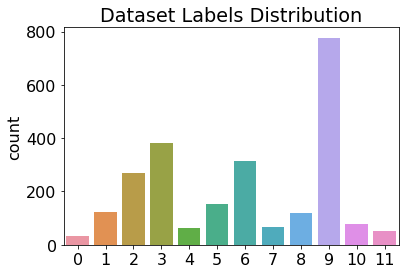

In [110]:
# plot labels distribution 
sns.countplot( x = y_train) 
plt.title('Dataset Labels Distribution')
plt.show()

As we can see dataset is pretty unbalanced. But, looking at early subs, more prominent classes do not seem to be the best predicted. Why? 

In [111]:
labels = np.unique(np.fromiter([i for i in y_train], np.int32) )
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=labels, y=y_train) 
y_train = tfk.utils.to_categorical(y_train) 

In [112]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=seed, stratify=y_train) 

In [113]:
train_data = np.concatenate([x for x in x_train]) 
print(train_data.shape) 
scaler = preprocessing.RobustScaler().fit(train_data) #robust scaler best to time, outliers? 

x_train_trans = [] 
for el in x_train: 
    x_train_trans.append(scaler.transform(el))
del x_train 

x_test_trans = [] 
for el in x_test :
    x_test_trans.append(scaler.transform(el))

x_train = np.asarray(x_train_trans) 
x_test = np.asarray(x_test_trans)
#x_train

(69948, 6)


In [114]:
# check 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 
x_train[0][1]
y_train[0]

(1943, 36, 6) (1943, 12) (486, 36, 6) (486, 12)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

# **1DCNN**

In [115]:
input_shape = (36,6)

In [116]:
def build_ffnn_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn_1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    pooling_1 = tfkl.MaxPooling1D()(cnn_1)
    cnn_2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(pooling_1)

    add = tf.keras.layers.Add()([pooling_1, cnn_2]) #skip connection 
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(add)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
        
    hidden_layer1 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden1', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0001))(gap) 
    hidden_layer2 = tfkl.Dense(units=256, activation ='relu', name = 'Hidden2', kernel_regularizer = tfk.regularizers.L2(l2 = 0.0001))(hidden_layer1) 
    
    output_layer = tfkl.Dense(classes, activation='softmax', 
                              kernel_initializer=tfk.initializers.GlorotUniform(seed))(hidden_layer2)
      
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [117]:
model = build_ffnn_classifier(input_shape, 12)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 36, 256)      4864        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 18, 256)      0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 18, 256)      196864      max_pooling1d_6[0][0]            
______________________________________________________________________________________________

In [118]:
history1 = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (x_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 1s 15ms/step - loss: 3.5987 - accuracy: 0.1935 - val_loss: 2.8166 - val_accuracy: 0.4012
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 2.4739 - accuracy: 0.3603 - val_loss: 2.2241 - val_accuracy: 0.3724
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 2.1257 - accuracy: 0.4097 - val_loss: 2.0091 - val_accuracy: 0.3971
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 1.9247 - accuracy: 0.4107 - val_loss: 2.0209 - val_accuracy: 0.4383
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 1.7243 - accuracy: 0.4385 - val_loss: 1.8160 - val_accuracy: 0.4383
Epoch 6/200
31/31 [==============================] - 0s 8ms/step - loss: 1.6047 - accuracy: 0.4879 - val_loss: 1.5701 - val_accuracy: 0.4979
Epoch 7/200
31/31 [==============================] - 0s 7ms/step - loss: 1.5759 - accuracy: 0.5059 - val_loss: 1.8339 - val_accuracy: 0.4671
Epoch 8/200


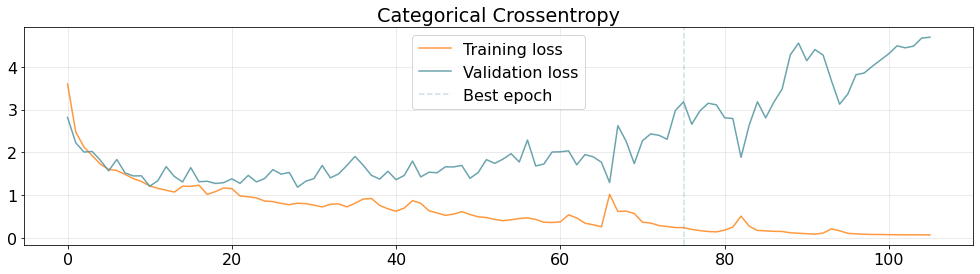

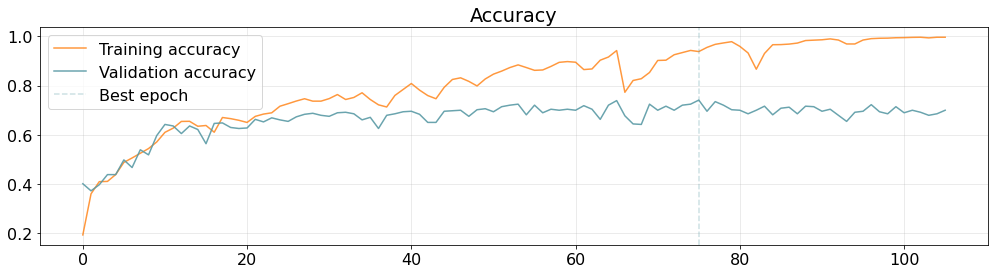

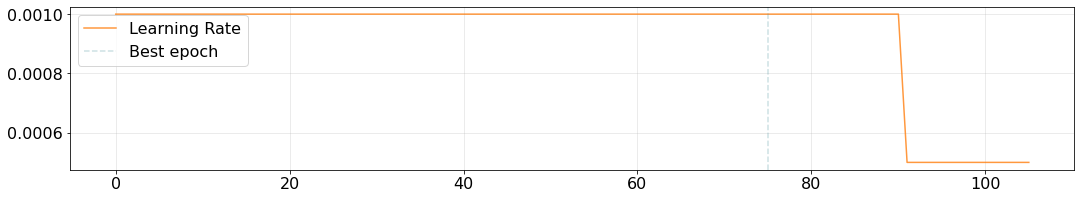

In [119]:
best_epoch = np.argmax(history1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [120]:
predictions = model.predict(x_test)
predictions.shape

(486, 12)

16/16 [==============================] - 0s 2ms/step - loss: 0.0492 - accuracy: 0.0000e+00
{'loss': 0.049178723245859146, 'accuracy': 0.0}
Accuracy: 0.7407
Precision: 0.6872
Recall: 0.5872
F1: 0.6209
F1 (per class): [0.4        0.62222222 0.90740741 0.61111111 0.42105263 0.43636364
 0.91935484 0.2        0.89795918 0.78977273 0.84615385 0.4       ]


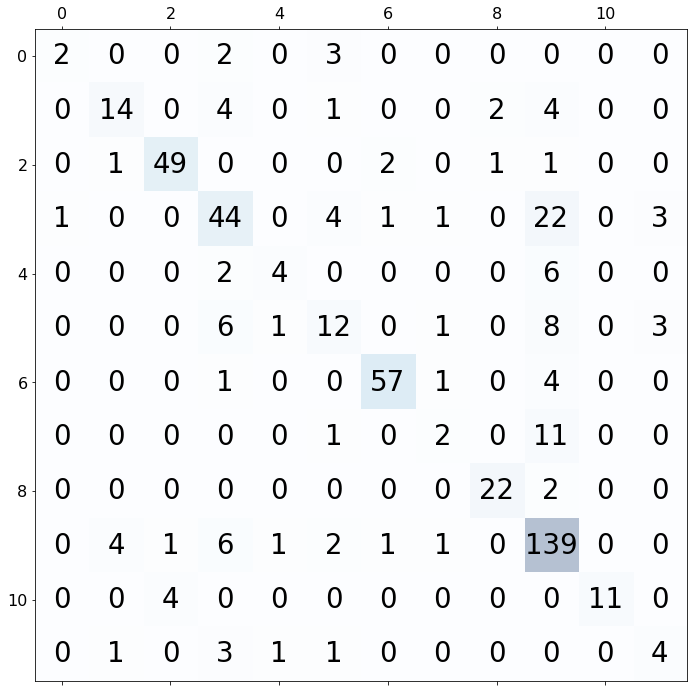

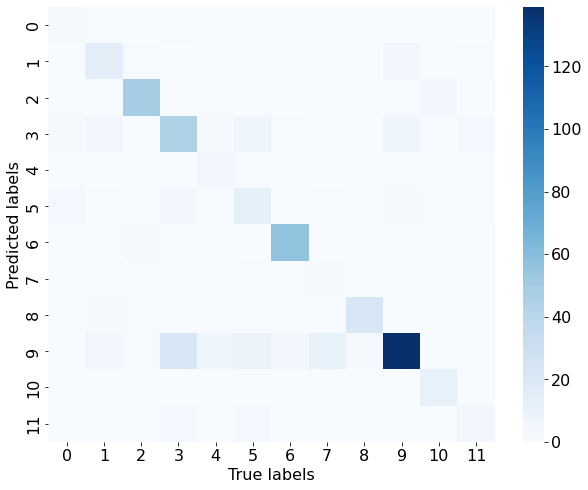

In [121]:
metrics = model.evaluate(x_test, return_dict=True)
print(metrics)

labels = y_test 
predictions = model.predict(x_test) 
assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):' ,f1_classes)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(12,12))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [122]:
model.save('sub4')

2022-12-13 11:55:36.047057: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [129]:
import pickle 
with open(r'scaler', 'wb') as f: 
    pickle.dump(scaler, f)